# Debug energy conservation implementation

Why does it crash and what could we do about it?

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [75]:
from cbrain.imports import *
from cbrain.utils import *
from matplotlib.animation import FuncAnimation
from IPython.display import SVG, HTML
from utils import *

In [5]:
DATA_DIR = '/scratch/05488/tg847872/debug/'
REF_DIR = '/scratch/05488/tg847872/fluxbypass_aqua/'

In [67]:
DT = 1800

## Why do we crash?

In [100]:
df1 = xr.open_mfdataset(f'{DATA_DIR}*F001.*h1*', decode_times=False)
dref = xr.open_mfdataset(f'{REF_DIR}*h1*0000-01-0[1-2]*', decode_times=False)

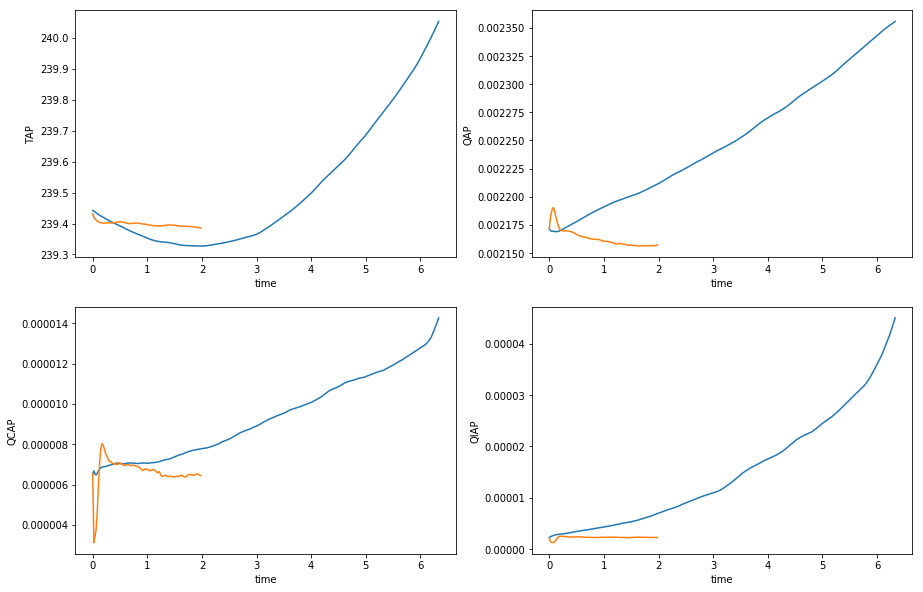

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
[df1[v].isel(time=slice(0, -2, 1)).mean(('lat', 'lon', 'lev')).plot(ax=ax) 
 for v, ax in zip(['TAP', 'QAP', 'QCAP', 'QIAP'], axes.flat)];
[dref[v].isel(time=slice(0, None, 1)).mean(('lat', 'lon', 'lev')).plot(ax=ax) 
 for v, ax in zip(['TAP', 'QAP', 'QCAP', 'QIAP'], axes.flat)];

QC and QI(!) increase very rapidly, basically from the start. Is this global or local?

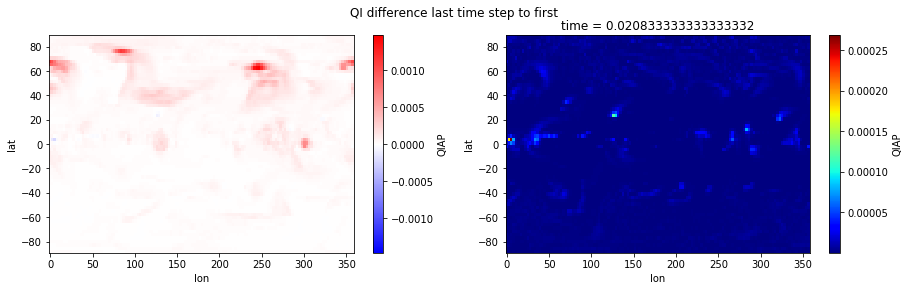

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
(df1.QIAP.isel(time=-2).mean('lev') - df1.QIAP.isel(time=1).mean('lev')).plot(cmap='bwr', ax=axes[0]);
df1.QIAP.isel(time=1).mean('lev').plot(cmap='jet', ax=axes[1]);
fig.suptitle('QI difference last time step to first');

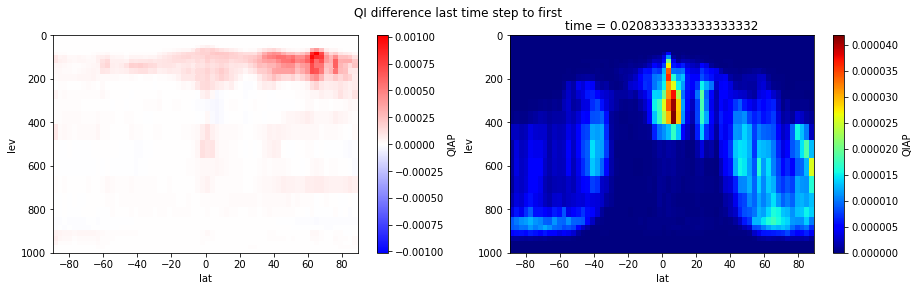

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
(df1.QIAP.isel(time=-2).mean('lon') - df1.QIAP.isel(time=1).mean('lon')).plot(cmap='bwr', yincrease=False, ax=axes[0]);
df1.QIAP.isel(time=1).mean('lon').plot(cmap='jet', ax=axes[1], yincrease=False);
fig.suptitle('QI difference last time step to first');

So these are huge increases, particularly in regions where there shouldn't be much ice at all. This is right at the end of the run however when things have probably gotten off the rails already. The increase is happening from the start however. Maybe looking at the one day differences is more enlightening.

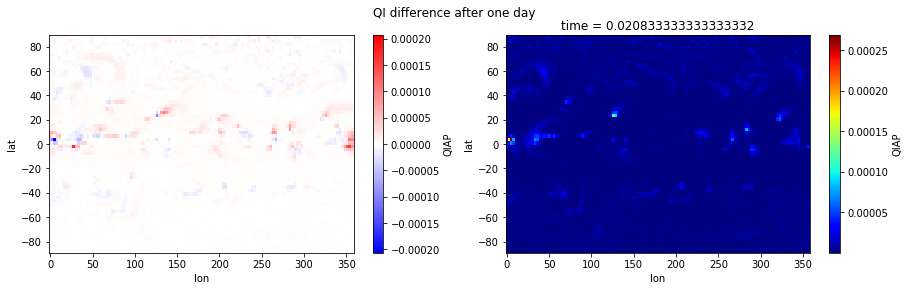

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
(df1.QIAP.isel(time=48).mean('lev') - df1.QIAP.isel(time=1).mean('lev')).plot(cmap='bwr', ax=axes[0]);
df1.QIAP.isel(time=1).mean('lev').plot(cmap='jet', ax=axes[1]);
fig.suptitle('QI difference after one day');

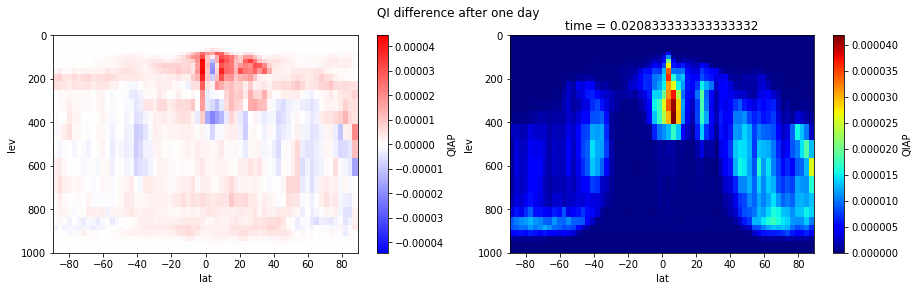

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
(df1.QIAP.isel(time=48).mean('lon') - df1.QIAP.isel(time=1).mean('lon')).plot(cmap='bwr', yincrease=False, ax=axes[0]);
df1.QIAP.isel(time=1).mean('lon').plot(cmap='jet', ax=axes[1], yincrease=False);
fig.suptitle('QI difference after one day');

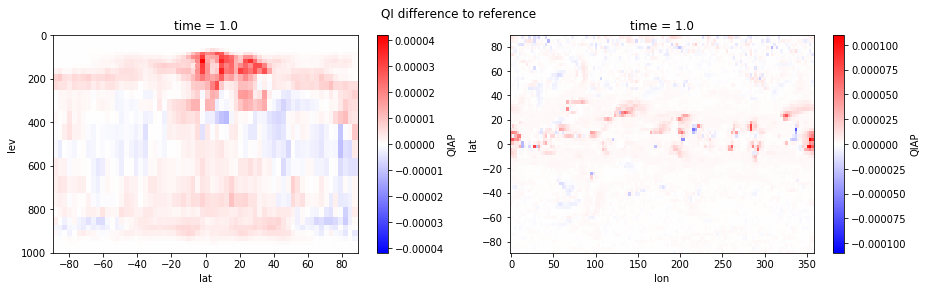

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
(df1.QIAP.isel(time=48).mean('lon') - dref.QIAP.isel(time=48).mean('lon')).plot(cmap='bwr', yincrease=False, ax=axes[0]);
(df1.QIAP.isel(time=48).mean('lev') - dref.QIAP.isel(time=48).mean('lev')).plot(cmap='bwr', ax=axes[1]);
fig.suptitle('QI difference to reference');

So we are red mostly where there isn't much ice to begin with and then it seems at the tropopause above convection.

## Why are we getting this much ice and liquid water!?

NNDQI and NNDQC are the only sources/sinks for ice and liquid!

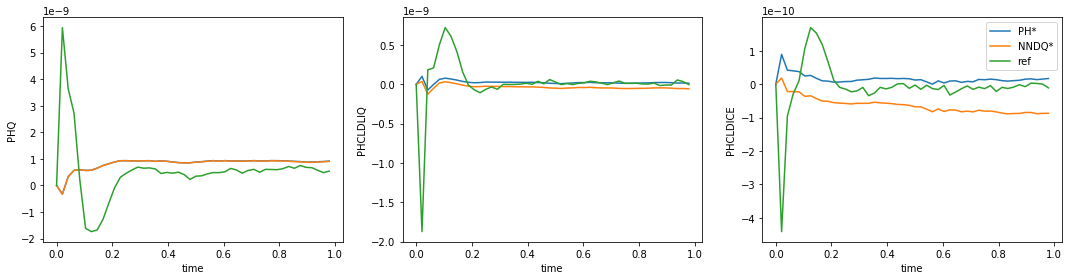

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
[df1[v].isel(time=slice(0, 48, 1)).mean(('lat', 'lon', 'lev')).plot(ax=ax, label='PH*') 
 for v, ax in zip(['PHQ', 'PHCLDLIQ', 'PHCLDICE'], axes.flat)]
[df1[v].isel(time=slice(0, 48, 1)).mean(('lat', 'lon', 'lev')).plot(ax=ax, label='NNDQ*') 
 for v, ax in zip(['NNDQ', 'NNDQC', 'NNDQI'], axes.flat)]
[dref[v].isel(time=slice(0, 48, 1)).mean(('lat', 'lon', 'lev')).plot(ax=ax, label='ref') 
 for v, ax in zip(['PHQ', 'PHCLDLIQ', 'PHCLDICE'], axes.flat)]
axes[-1].legend(); plt.tight_layout()

Here we have a problem. The actual difference and the NN tendencies do not agree. In fact, the actual differences are much higher! Let's go hunting!

My suspicion is that it's the qneg3 correction!

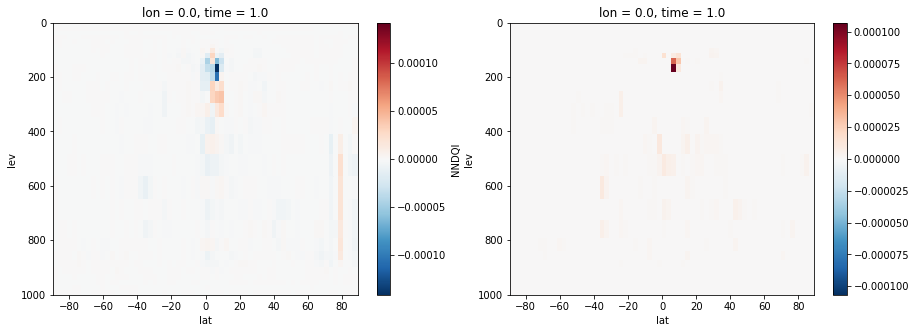

In [68]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
(df1['NNDQI']*DT).isel(time=48, lon=0).plot(yincrease=False, ax=axes[0])
(df1['PHCLDICE']*DT - df1['NNDQI']*DT).isel(time=48, lon=0).plot(yincrease=False, ax=axes[1]);

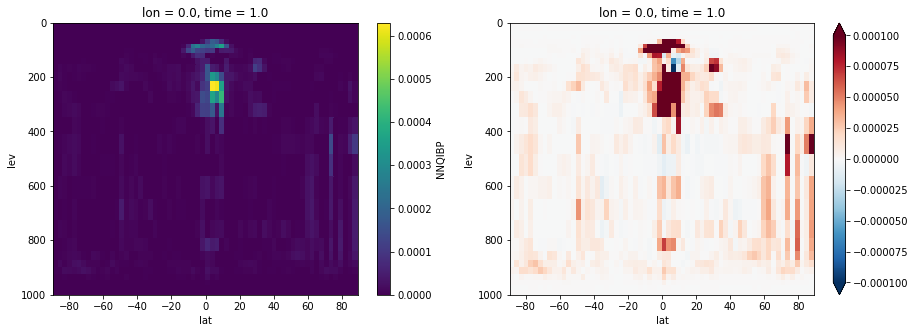

In [74]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
df1['NNQIBP'].isel(time=48, lon=0).plot(yincrease=False, ax=axes[0])
(df1['NNQIBP'] + df1['NNDQI']*DT).isel(time=48, lon=0).plot(yincrease=False, ax=axes[1], vmin=-1e-4, vmax=1e-4, 
                                                            cmap='RdBu_r');

In [134]:
def get_neg(ds, var1, var2):
    Qafter = ds[var1] + ds[var2]*DT
    return -np.sum(np.minimum(Qafter.values, 0))

In [145]:
get_neg(df1.isel(time=48), 'NNQIBP', 'NNDQI'), get_neg(df1.isel(time=48), 'NNQCBP', 'NNDQC')

(0.04687299, 0.031508625)

So here is our problem. We are predicting drying that would cause the concentrations to be below zero. Why are we predicting this? Like one question is:

- Does this happen that strongly also on the validation set offline?

## Check the NN offline

In [101]:
KERAS_DIR = '/home1/05488/tg847872/saved_models/'
m = keras.models.load_model(f'{KERAS_DIR}/F001_fbp_engy_cons_sample1_max_rs_deep.h5')

In [102]:
mean = np.loadtxt(f'{KERAS_DIR}/F001_fbp_engy_cons_sample1_max_rs_deep/inp_means.txt', delimiter=',')
std = np.loadtxt(f'{KERAS_DIR}/F001_fbp_engy_cons_sample1_max_rs_deep/inp_max_rs.txt', delimiter=',')

In [103]:
dref['NNTBP'] = dref['TAP'] - dref['TPHYSTND']*DT
dref['NNQBP'] = dref['QAP'] - dref['PHQ']*DT
dref['NNQCBP'] = dref['QCAP'] - dref['PHCLDLIQ']*DT
dref['NNQIBP'] = dref['QIAP'] - dref['PHCLDICE']*DT
dref['NNVBP'] = dref['VAP'] - dref['VPHYSTND']*DT
dref['NNPS'] = dref['PS']
dref['NNSOLIN'] = dref['SOLIN']

In [104]:
dref['SHFLX'].load(); dref['LHFLX'].load();
dref['NNSHF'] = dref['SHFLX'].copy()
dref['NNLHF'] = dref['LHFLX'].copy()

In [105]:
dref['NNSHF'].values[1:] = dref['SHFLX'].values[:-1]
dref['NNLHF'].values[1:] = dref['LHFLX'].values[:-1]

In [149]:
# Get predictions for 48th time step
inps = get_cb_inps(dref, 95, mean, std)
preds = m.predict(inps.reshape(154, -1).T, 4096).T.reshape(126, 64, 128); preds.shape

(126, 64, 128)

In [150]:
predDQI = preds[90:120] / L_V

In [151]:
dref['PHCLDICE'].load()
dref['PDQI'] = dref['PHCLDICE'].copy()
dref['PDQI'].values[95] = predDQI

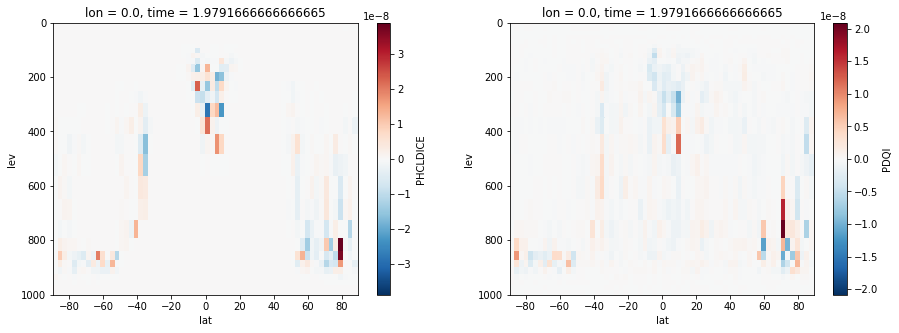

In [155]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
dref['PHCLDICE'].isel(time=95, lon=0).plot(yincrease=False, ax=axes[0])
dref['PDQI'].isel(time=95, lon=0).plot(yincrease=False, ax=axes[1]);

In [154]:
get_neg(dref.isel(time=95), 'NNQIBP', 'PDQI'), get_neg(dref.isel(time=95), 'NNQIBP', 'PHCLDICE')

(0.027682977, -0.0)

This suggests that this is also happening in the offline predictions, maybe not quite as bad. The raw output does look pretty random. 

In [156]:
x = np.array([0.01, 2, 5, 2])

In [158]:
l = np.log(x); l

array([-4.60517019,  0.69314718,  1.60943791,  0.69314718])

In [159]:
np.sum(l)

-1.6094379124340996